In [1]:
import os
import pickle
import re
import pprint
import numpy as np
import sympy as sp
import openturns as ot
import matplotlib.pyplot as plt
import trimesh as tr

from math import pi
from joblib import Parallel, delayed
from importlib import reload
from IPython.display import display, clear_output
from time import time
from sympy.printing import latex
from trimesh import viewer as trview
import sklearn

from scipy.optimize import OptimizeResult, minimize, basinhopping, differential_evolution, brute

import tqdm
import otaf

# AI stuff
from efficient_kan import KAN, KANLinear
from lion_pytorch import Lion

ot.Log.Show(ot.Log.NONE)
np.set_printoptions(suppress=True)
ar = np.array


# Notebook for the analysis of a system comprised of N + 2 parts, 2 plates with N = N1 x N2 holes, and N pins. 

### Defintion on global descriptive parameters

In [2]:
NX = 2 ## Number of holes on x axis
NY = 2 ## Number of holes on y axis
Dext = 10 ## Diameter of holes in mm
Dint = 9.8 ## Diameter of pins in mm
EH = 20 ## Distance between the hole axises
hPlate = 10 #Height of the plates in mm
hPin = 20 #Height of the pins in mm

CIRCLE_RESOLUTION = 15 # NUmber of points to model the contour of the outer holes

### Defining and constructing the system data dictionary

The plates have NX * NY + 1 surfaces. The lower left point has coordinate 0,0,0

We only model the surfaces that are touching. 

In [3]:
N_PARTS = NX * NY * 2
LX = (NX + 1) * EH
LY = (NY + 1) * EH

contour_points = ar([[0,0,0],[LX,0,0],[LX,LY,0],[0,LY,0]])

R0 = ar([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
x_, y_, z_ = R0[0], R0[1], R0[2]

Frame1 = ar([z_,y_,-x_])
Frame2 = ar([-z_,y_,x_])

First we define the base part dictionaries for the upper and lower plate, without holes

In [4]:
system_data = {
    "PARTS" : {
        '0' : {
            "a" : {
                "FRAME": Frame1,
                "POINTS": {'A0' : ar([0,0,0]),
                           'A1' : ar([LX,0,0]),
                           'A2' : ar([LX,LY,0]),
                           'A3' : ar([0,LY,0]),
                        },
                "TYPE": "plane",
                "INTERACTIONS": ['P1a'],
                "CONSTRAINTS_D": ["PERFECT"],
                "CONSTRAINTS_G": ["SLIDING"],            
            }
        },
        '1' : {
            "a" : {
                "FRAME": Frame2,
                "POINTS": {'A0' : ar([0,0,0]),
                           'A1' : ar([LX,0,0]),
                           'A2' : ar([LX,LY,0]),
                           'A3' : ar([0,LY,0]),
                        },
                "TYPE": "plane",
                "INTERACTIONS": ['P0a'],
                "CONSTRAINTS_D": ["PERFECT"],
                "CONSTRAINTS_G": ["SLIDING"],            
            }
        }  
    },
    "LOOPS": {
        "COMPATIBILITY": {
        },
    },
    "GLOBAL_CONSTRAINTS": "3D",
}

Then we iterate over the pin dimensions NX and NY, and create the corresponding holes and pins. At the same time there is 1 loop per pin

In [5]:
alpha_gen = otaf.common.alphabet_generator()
next(alpha_gen) # skipping 'a' as it has already been used above
part_id = 2 # Start part index for pins
for i in range(NX):
    for j in range(NY):
        pcor = ar([(i+1)*EH, (j+1)*EH, 0]) # Point coordinate for hole / pins
        slab = next(alpha_gen) # Surface label, same for each mating pin so its easeir to track
        # Creating pin
        system_data["PARTS"][str(part_id)] = {}
        system_data["PARTS"][str(part_id)][slab] = {
            "FRAME": Frame1, # Frame doesn't really matter, as long as x is aligned on the axis
            "ORIGIN": pcor, 
            "TYPE": "cylinder",
            "RADIUS": Dint / 2,
            "EXTENT_LOCAL": {"x_max": hPin/2, "x_min": -hPin/2},
            "INTERACTIONS": [f"P0{slab}", f"P1{slab}"], 
            "SURFACE_DIRECTION": "centrifugal",
            "CONSTRAINTS_D": ["PERFECT"], # No defects on the pins
            "BLOCK_ROTATIONS_G": 'x', # The pins do not rotate around their axis
            "BLOCK_TRANSLATIONS_G": 'x', # The pins do not slide along their axis
        }
        # Adding hole to part 0
        system_data["PARTS"]["0"][slab] = {
            "FRAME": Frame1,
            "ORIGIN": pcor, 
            "TYPE": "cylinder",
            "RADIUS": Dext / 2,
            "EXTENT_LOCAL": {"x_max": hPin/2, "x_min": -hPin/2},
            "INTERACTIONS": [f"P{part_id}{slab}"], 
            "SURFACE_DIRECTION": "centripetal",
        }
        # Adding hole to part 1
        system_data["PARTS"]["1"][slab] = {
            "FRAME": Frame2,
            "ORIGIN": pcor, 
            "TYPE": "cylinder",
            "RADIUS": Dext / 2,
            "EXTENT_LOCAL": {"x_max": hPin/2, "x_min": -hPin/2},
            "INTERACTIONS": [f"P{part_id}{slab}"],
            "SURFACE_DIRECTION": "centripetal",
        }
        # Construct Compatibility loop
        loop_id = f"L{part_id-1}"
        formater = lambda i,l : f"P{i}{l}{l.upper()}0" 
        system_data["LOOPS"]["COMPATIBILITY"][loop_id] = f"P0aA0 -> {formater(0,slab)} -> {formater(part_id,slab)} -> {formater(1,slab)} -> P1aA0"
        part_id += 1
        

In [6]:
system_data["PARTS"]

{'0': {'a': {'FRAME': array([[ 0,  0,  1],
          [ 0,  1,  0],
          [-1,  0,  0]]),
   'POINTS': {'A0': array([0, 0, 0]),
    'A1': array([60,  0,  0]),
    'A2': array([60, 60,  0]),
    'A3': array([ 0, 60,  0])},
   'TYPE': 'plane',
   'INTERACTIONS': ['P1a'],
   'CONSTRAINTS_D': ['PERFECT'],
   'CONSTRAINTS_G': ['SLIDING']},
  'b': {'FRAME': array([[ 0,  0,  1],
          [ 0,  1,  0],
          [-1,  0,  0]]),
   'ORIGIN': array([20, 20,  0]),
   'TYPE': 'cylinder',
   'RADIUS': 5.0,
   'EXTENT_LOCAL': {'x_max': 10.0, 'x_min': -10.0},
   'INTERACTIONS': ['P2b'],
   'SURFACE_DIRECTION': 'centripetal'},
  'c': {'FRAME': array([[ 0,  0,  1],
          [ 0,  1,  0],
          [-1,  0,  0]]),
   'ORIGIN': array([20, 40,  0]),
   'TYPE': 'cylinder',
   'RADIUS': 5.0,
   'EXTENT_LOCAL': {'x_max': 10.0, 'x_min': -10.0},
   'INTERACTIONS': ['P3c'],
   'SURFACE_DIRECTION': 'centripetal'},
  'd': {'FRAME': array([[ 0,  0,  1],
          [ 0,  1,  0],
          [-1,  0,  0]]),
   'OR

In [7]:
SDA = otaf.AssemblyDataProcessor(system_data)
SDA.generate_expanded_loops()

In [8]:
CLH = otaf.CompatibilityLoopHandling(SDA)
compatibility_expressions = CLH.get_compatibility_expression_from_FO_matrices()

In [9]:
ILH = otaf.InterfaceLoopHandling(SDA, CLH, circle_resolution=CIRCLE_RESOLUTION)
interface_constraints = ILH.get_interface_loop_expressions()

	 IF STATEMENT 3 NOT FACING
	 IF STATEMENT 6 NOT FACING
	 IF STATEMENT 3 NOT FACING
	 IF STATEMENT 6 NOT FACING
	 IF STATEMENT 3 NOT FACING
	 IF STATEMENT 6 NOT FACING
	 IF STATEMENT 3 NOT FACING
	 IF STATEMENT 6 NOT FACING
	 IF STATEMENT 3 FACING
	 IF STATEMENT 6 FACING
	 IF STATEMENT 3 FACING
	 IF STATEMENT 6 FACING
	 IF STATEMENT 3 FACING
	 IF STATEMENT 6 FACING
	 IF STATEMENT 3 FACING
	 IF STATEMENT 6 FACING
	 IF STATEMENT 3 NOT FACING
	 IF STATEMENT 6 NOT FACING
	 IF STATEMENT 3 FACING
	 IF STATEMENT 6 FACING
	 IF STATEMENT 3 NOT FACING
	 IF STATEMENT 6 NOT FACING
	 IF STATEMENT 3 FACING
	 IF STATEMENT 6 FACING
	 IF STATEMENT 3 NOT FACING
	 IF STATEMENT 6 NOT FACING
	 IF STATEMENT 3 FACING
	 IF STATEMENT 6 FACING
	 IF STATEMENT 3 NOT FACING
	 IF STATEMENT 6 NOT FACING
	 IF STATEMENT 3 FACING
	 IF STATEMENT 6 FACING
Processing part 0, surface b for cylinder-to-cylinder interactions.
usedGMatDat [['0', 'b', 'B0', '2', 'b', 'B0']]
Found 1 used gap matrices.
unusedGMatDat [['0', 'b', 

In [10]:
#SDA.get_notebook_scene_sphere_clouds()

In [11]:
SOCAM = otaf.SystemOfConstraintsAssemblyModel(
    compatibility_expressions, interface_constraints
)

SOCAM.embedOptimizationVariable()

print(len(SOCAM.deviation_symbols), SOCAM.deviation_symbols)

32 [v_d_0, w_d_0, beta_d_0, gamma_d_0, v_d_2, w_d_2, beta_d_2, gamma_d_2, v_d_5, w_d_5, beta_d_5, gamma_d_5, v_d_7, w_d_7, beta_d_7, gamma_d_7, v_d_8, w_d_8, beta_d_8, gamma_d_8, v_d_10, w_d_10, beta_d_10, gamma_d_10, v_d_11, w_d_11, beta_d_11, gamma_d_11, v_d_13, w_d_13, beta_d_13, gamma_d_13]


In [12]:
tol = 0.1 * np.sqrt(2)
Cm = 1  # Process capability

# Defining the uncertainties on the position and orientation uncertainties.
sigma_e_pos = tol / (6 * Cm)
theta_max = tol / hPlate
sigma_e_theta = (2 * theta_max) / (6 * Cm)

In [13]:
RandDeviationVect = otaf.uncertainty.get_composed_normal_defect_distribution(
    defect_names=SOCAM.deviation_symbols,
    sigma_dict = {"alpha":sigma_e_theta, 
                  "beta":sigma_e_theta,
                  "gamma":sigma_e_theta, 
                  "u":sigma_e_pos, 
                  "v":sigma_e_pos, 
                  "w":sigma_e_pos})
dim_devs = int(RandDeviationVect.getDimension())

def get_uniform_from_deviation_vect(composed_distribution):
    """To construct a composed distribution of uniform distributions from
    normal distributions to feed the ai cause it struggles. 
    """
    uni_dist_list = []
    parameters = composed_distribution.getParametersCollection()
    for i in range(len(parameters)-1):
        #assert parameter[0]==0.0, "We said 0 mean!"
        std = parameters[i][1] #We assume all parameters are normal distributions!!
        a = -2*std
        b = 2*std
        uni_dist_list.append(ot.Uniform(a,b))
    return ot.ComposedDistribution(uni_dist_list)

UniRandDevVect = get_uniform_from_deviation_vect(RandDeviationVect)

In [14]:
# Define the seed, sample size, and file paths
SEED = 420  # Example seed value
sample_size = 100000
model_name = f"model{NX}x{NY}Pins"
sample_filename = f'STORAGE/training_sample_{sample_size}_seed_{SEED}_{model_name}_ai.npy'
results_filename = f'STORAGE/training_results_{sample_size}_seed_{SEED}_{model_name}_ai.npy'

# Ensure reproducibility by setting the seed
np.random.seed(SEED)

# Check if the sample and results files already exist
if os.path.exists(sample_filename) and os.path.exists(results_filename):
    with open(sample_filename, 'rb') as file:
        TRAIN_SAMPLE = np.load(file)
    with open(results_filename, 'rb') as file:
        TRAIN_RESULTS = np.load(file)
    print("Loaded existing sample and results from file.")
else:
    # Generate the sample
    dist = otaf.uncertainty.multiply_composed_distribution_with_constant(
        RandDeviationVect, 1.05) # We now work with low failure probabilities
    #TRAIN_SAMPLE = np.array(otaf.uncertainty.generateLHSExperiment(dist, sample_size))
    TRAIN_SAMPLE = np.array(dist.getSample(sample_size),dtype="float32")
    # Compute the results
    TRAIN_RESULTS = otaf.uncertainty.compute_gap_optimizations_on_sample_batch(
        SOCAM,
        TRAIN_SAMPLE,
        bounds=None,
        n_cpu=-2,
        progress_bar=True,
        dtype="float32"
    )
    #TRAIN_RESULTS = np.array([res.x for res in TRAIN_RESULTS],dtype="float32") #Before we took only the s variable, but lets rather train on the whole vector of gaps.
    
    # Save the sample and results
    with open(sample_filename, 'wb') as file:
        np.save(file, TRAIN_SAMPLE)
    with open(results_filename, 'wb') as file:
        np.save(file, TRAIN_RESULTS)
    print("Generated and saved new sample and results with seed.")

# Assign X and y from TRAIN_SAMPLE and TRAIN_RESULTS
Xtrain = TRAIN_SAMPLE
ytrain = TRAIN_RESULTS
train_failure_ratio = np.where(ytrain[...,-1]<0,1,0).sum()/sample_size
train_success_ratio = np.where(ytrain[...,-1]>=0,1,0).sum()/sample_size
print(f"Ratio of failed simulations in sample : {np.where(ytrain[...,-1]<0,1,0).sum()/sample_size}")
out_dim = ytrain.shape[-1]

Loaded existing sample and results from file.
Ratio of failed simulations in sample : 0.07028


In [15]:
# Define the seed, sample size, and file paths
SEED_valid = 3141996  # Example seed value
sample_size_valid = 50000
model_name = f"model{NX}x{NY}Pins"
sample_filename = f'STORAGE/validation_sample_{sample_size_valid}_seed_{SEED_valid}_{model_name}_ai.npy'
results_filename = f'STORAGE/validation_results_{sample_size_valid}_seed_{SEED_valid}_{model_name}_ai.npy'

# Ensure reproducibility by setting the seed
np.random.seed(SEED_valid)

# Check if the sample and results files already exist
if os.path.exists(sample_filename) and os.path.exists(results_filename):
    with open(sample_filename, 'rb') as file:
        VALID_SAMPLE = np.load(file)
    with open(results_filename, 'rb') as file:
        VALID_RESULTS = np.load(file)
    print("Loaded existing sample and results from file.")
else:
    # Generate the sample
    dist = otaf.uncertainty.multiply_composed_distribution_with_constant(
        RandDeviationVect, 1.05) # We now work with low failure probabilities
    #VALID_SAMPLE = np.array(otaf.uncertainty.generateLHSExperiment(dist, sample_size_valid))
    VALID_SAMPLE = np.array(dist.getSample(sample_size_valid),dtype="float32")
    # Compute the results
    VALID_RESULTS = otaf.uncertainty.compute_gap_optimizations_on_sample_batch(
        SOCAM,
        VALID_SAMPLE,
        n_cpu=-2,
        progress_bar=True,
        dtype="float32"
    )
    
    # Save the sample and results
    with open(sample_filename, 'wb') as file:
        np.save(file, VALID_SAMPLE)
    with open(results_filename, 'wb') as file:
        np.save(file, VALID_RESULTS)
    print("Generated and saved new sample and results with seed for validation.")

# Assign X and y from VALID_SAMPLE and VALID_RESULTS
Xvalid = VALID_SAMPLE
yvalid = VALID_RESULTS
print(f"Ratio of failed simulations in validation sample : {np.where(yvalid[...,-1]<0,1,0).sum()/sample_size_valid}")
out_dim = yvalid.shape[-1]

Loaded existing sample and results from file.
Ratio of failed simulations in validation sample : 0.07012


In [16]:
y_plays = ytrain[:, :-1]
y_slack = ytrain[:, -1]
dim_plays = y_plays.shape[1]
dim_devs

32

load = False
y_slack = ytrain[..., -1]
save_path = f'STORAGE/AI_MODEL_3D_DIM_{dim_devs}_SLACK_FROM_DEFECTS.pth'
neural_model_dev_2_slack = otaf.surrogate.NeuralRegressorNetwork(
    dim_devs, 1,
    Xtrain, y_slack, 
    clamping=True, 
    finish_critertion_epoch=100,
    max_epochs=150, 
    batch_size=35000, 
    compile_model=True, 
    train_size=0.70, 
    save_path = save_path,
    input_description=RandDeviationVect.getDescription(),
    display_progress_disable=True)

lr=0.00025
neural_model_dev_2_slack.model = otaf.torch.nn.Sequential(
    #KAN([dim_devs, 80, 40, 1])
    *otaf.surrogate.get_custom_mlp_layers([dim_devs, 2500, 500, 100], activation_class=otaf.torch.nn.LeakyReLU),
    KAN([100, 10, 1])
)

neural_model_dev_2_slack.optimizer = otaf.torch.optim.AdamW(neural_model_dev_2_slack.parameters(), lr=lr, weight_decay=0.01)  # Lion(neural_model_dev_2_slack.parameters(), lr=lr, weight_decay=0.0001) #otaf.torch.optim.AdamW(neural_model_dev_2_slack.parameters(), lr=lr, weight_decay=0.001) # #Adam(neural_model.model.parameters(), lr=lr)#
otaf.surrogate.initialize_model_weights(neural_model_dev_2_slack.model)
neural_model_dev_2_slack.scheduler = otaf.torch.optim.lr_scheduler.ExponentialLR(neural_model_dev_2_slack.optimizer, 1.0) #LinearLR(neural_model.optimizer, 1, 0.1, 200)
neural_model_dev_2_slack.loss_fn = otaf.torch.nn.MSELoss() #otaf.torch.nn.HuberLoss(delta=0.001) #otaf.surrogate.LimitSpaceFocusedLoss(0.00001, 5, square=True)#neural_model.loss_fn = otaf.surrogate.PositiveLimitSpaceFocusedLoss(0.0001, 1.73, 3, square=True)
if os.path.exists(save_path) and load:
    neural_model_dev_2_slack.load_model()
else :
    neural_model_dev_2_slack.train_model()
    neural_model_dev_2_slack.plot_results()
    neural_model_dev_2_slack.save_model()

load = False
y_slack = ytrain[..., -1]
save_path = f'STORAGE/AI_MODEL_3D_DIM_{dim_devs}_SLACK_FROM_DEFECTS.pth'
neural_model_dev_2_slack = otaf.surrogate.NeuralRegressorNetwork(
    dim_devs, 1,
    Xtrain, y_slack, 
    clamping=False, 
    finish_critertion_epoch=100,
    max_epochs=250, 
    batch_size=7000, 
    compile_model=True, 
    train_size=0.70, 
    save_path = save_path,
    input_description=RandDeviationVect.getDescription(),
    display_progress_disable=True)

lr=0.0001
neural_model_dev_2_slack.model = otaf.torch.nn.Sequential(
    *otaf.surrogate.get_custom_mlp_layers([dim_devs, 5*dim_devs], activation_class = otaf.torch.nn.SELU, 
        dropout_class = otaf.torch.nn.AlphaDropout, dropout_kwargs = {'p':0.25}
        ),
    *otaf.surrogate.get_custom_mlp_layers([dim_devs*5, dim_devs//2], activation_class = otaf.torch.nn.ReLU),
    KAN([dim_devs//2, dim_devs//3]),
    #otaf.torch.nn.AlphaDropout(p=0.10),
    *otaf.surrogate.get_custom_mlp_layers([dim_devs//3, 1], activation_class = otaf.torch.nn.ReLU))

neural_model_dev_2_slack.optimizer = Lion(neural_model_dev_2_slack.parameters(), lr=lr, weight_decay=0.0001) #otaf.torch.optim.AdamW(neural_model_dev_2_slack.parameters(), lr=lr, weight_decay=0.001) # #Adam(neural_model.model.parameters(), lr=lr)#
otaf.surrogate.initialize_model_weights(neural_model_dev_2_slack.model)
neural_model_dev_2_slack.scheduler = otaf.torch.optim.lr_scheduler.ExponentialLR(neural_model_dev_2_slack.optimizer, 1.0025) #LinearLR(neural_model.optimizer, 1, 0.1, 200)
neural_model_dev_2_slack.loss_fn = otaf.torch.nn.MSELoss() #otaf.torch.nn.HuberLoss(delta=0.001) #otaf.surrogate.LimitSpaceFocusedLoss(0.00001, 5, square=True)#neural_model.loss_fn = otaf.surrogate.PositiveLimitSpaceFocusedLoss(0.0001, 1.73, 3, square=True)
if os.path.exists(save_path) and load:
    neural_model_dev_2_slack.load_model()
else :
    neural_model_dev_2_slack.train()
    neural_model_dev_2_slack.plot_results()
    neural_model_dev_2_slack.save_model()

## Binary classificiation of slack that is below a certain threshold with confidience level to optimize optimizations

[32, 392, 400, 312, 128]
	Epoch 001, Val Loss: 85755.921875, Ratio predicted: 0.928850, Ratio FN/TN 0.076079, TN: 27879, FP: 0, FN: 2121, TP: 0
	Epoch 002, Val Loss: 85755.046875, Ratio predicted: 0.928733, Ratio FN/TN 0.076079, TN: 27879, FP: 0, FN: 2121, TP: 0
	Epoch 003, Val Loss: 85754.140625, Ratio predicted: 0.928633, Ratio FN/TN 0.076079, TN: 27879, FP: 0, FN: 2121, TP: 0
	Epoch 004, Val Loss: 85753.140625, Ratio predicted: 0.928550, Ratio FN/TN 0.076079, TN: 27879, FP: 0, FN: 2121, TP: 0
	Epoch 005, Val Loss: 85751.875000, Ratio predicted: 0.928350, Ratio FN/TN 0.076079, TN: 27879, FP: 0, FN: 2121, TP: 0
	Epoch 006, Val Loss: 85750.195312, Ratio predicted: 0.927867, Ratio FN/TN 0.076007, TN: 27879, FP: 0, FN: 2119, TP: 2
	Epoch 007, Val Loss: 85747.890625, Ratio predicted: 0.926367, Ratio FN/TN 0.075893, TN: 27868, FP: 11, FN: 2115, TP: 6
	Epoch 008, Val Loss: 85744.664062, Ratio predicted: 0.924250, Ratio FN/TN 0.075548, TN: 27850, FP: 29, FN: 2104, TP: 17
	Epoch 009, Val Loss

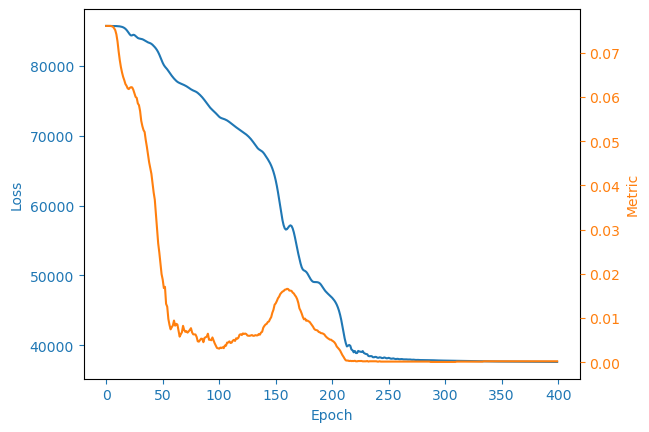

In [17]:
load = False
save_path = f'STORAGE/AI_MODEL_3D_DIM_{dim_devs}_BINARY_SLACK_CLASSIFIER.pth'
binary_slack_classifier = otaf.surrogate.BinaryClassificationModel(
    dim_devs, 2, 
    Xtrain, ytrain[:,-1], 
    slack_threshold=0.0,
    clamping=True, 
    clamping_threshold=2.0,
    max_epochs=400, 
    batch_size=70000, 
    train_size=0.70,
    display_progress_disable=True,
    squeeze_labels = True,
    labels_to_long = True,
    use_dual_target = False)

lr=0.001

binary_slack_classifier.model = otaf.torch.nn.Sequential(
    *otaf.surrogate.get_custom_mlp_layers([dim_devs, dim_devs*3], activation_class = otaf.torch.nn.LeakyReLU,),
    *otaf.surrogate.get_custom_mlp_layers([dim_devs*3, dim_devs*2], activation_class = otaf.torch.nn.SELU,
                                         dropout_class = otaf.torch.nn.AlphaDropout, dropout_kwargs = {'p':0.25}),
    *otaf.surrogate.get_custom_mlp_layers([dim_devs*2, dim_devs, dim_devs//2, 2], activation_class = otaf.torch.nn.GELU),
    otaf.torch.nn.Tanhshrink())

binary_slack_classifier.optimizer = otaf.torch.optim.AdamW(binary_slack_classifier.parameters(), lr=lr, weight_decay=0.0001)  # Lion(binary_slack_classifier.parameters(), lr=lr, weight_decay=0.0001) #Adam(neural_model.model.parameters(), lr=lr)#
weight =  otaf.torch.tensor([2.0/(train_success_ratio+1e-9), 2.0/(train_failure_ratio+1e-9)]).float()
binary_slack_classifier.criterion = otaf.torch.nn.CrossEntropyLoss(weight=weight, reduction='sum', label_smoothing=0.01) # otaf.torch.nn.BCEWithLogitsLoss(pos_weight=weight) # otaf.torch.nn.MSELoss()
otaf.surrogate.initialize_model_weights(binary_slack_classifier)
binary_slack_classifier.scheduler = otaf.torch.optim.lr_scheduler.ExponentialLR(binary_slack_classifier.optimizer, 1.0001) #LinearLR(neural_model.optimizer, 1, 0.1, 200)
binary_slack_classifier.train_model()
binary_slack_classifier.plot_results()

In [23]:
pred_class = binary_slack_classifier.evaluate_model(Xvalid).cpu().detach().numpy()
ground_truth = yvalid[:,-1]#np.array([res.x[-1] for res in ground_truth_full],dtype="float32")
ground_truth_binary = np.where(ground_truth<0,1,0) #ground truth for the failures.

# Optimize thresholds
optimization_results_fn_tn = otaf.surrogate.optimize_thresholds_with_alpha(pred_class, ground_truth_binary, bounds=[-5.0, 5.0], alpha_bounds=[1.0, 3.0], optimize_for="minimize_fn_maximize_tn")
optimization_results_tp_fp = otaf.surrogate.optimize_thresholds_with_alpha(pred_class, ground_truth_binary, bounds=[-5.0, 5.0], alpha_bounds=[1.0, 50.0], optimize_for="minimize_fp_maximize_tp", equality_decision="success")

print(f"Best Failure Threshold (minimize_fn_maximize_tn): {optimization_results_fn_tn['best_failure_threshold']}")
print(f"Best Success Threshold (minimize_fn_maximize_tn): {optimization_results_fn_tn['best_success_threshold']}")
print("Evaluation Metrics (minimize_fn_maximize_tn):", optimization_results_fn_tn['evaluation'])
print("Best Alpha (minimize_fn_maximize_tn):", optimization_results_fn_tn['best_alpha'])
print('\n')
print(f"Best Failure Threshold (maximize_tp_minimize_fp): {optimization_results_tp_fp['best_failure_threshold']}")
print(f"Best Success Threshold (maximize_tp_minimize_fp): {optimization_results_tp_fp['best_success_threshold']}")
print("Evaluation Metrics (maximize_tp_minimize_fp):", optimization_results_tp_fp['evaluation'])
print("Best Alpha (maximize_tp_minimize_fp):", optimization_results_tp_fp['best_alpha'])


   Normal return from subroutine COBYLA

   NFVALS =   43   F =-5.290925E-02    MAXCV =-0.000000E+00
   X = 5.000000E+00  -4.264483E+00   1.000000E+00

   Normal return from subroutine COBYLA

   NFVALS =   74   F =-8.065230E-02    MAXCV =-0.000000E+00
   X = 3.021739E+00   5.751165E-01   1.000000E+00
Best Failure Threshold (minimize_fn_maximize_tn): 5.0
Best Success Threshold (minimize_fn_maximize_tn): -4.264482737972642
Evaluation Metrics (minimize_fn_maximize_tn): {'confusion_matrix': array([[46403,    91],
       [ 2784,   722]]), 'accuracy': 0.9425, 'precision': 0.8880688806888068, 'recall': 0.20593268682258983, 'f1_score': 0.33433665200277835, 'true_negatives': 46403, 'false_positives': 91, 'false_negatives': 2784, 'true_positives': 722}
Best Alpha (minimize_fn_maximize_tn): 1.0


Best Failure Threshold (maximize_tp_minimize_fp): 3.0217391765795454
Best Success Threshold (maximize_tp_minimize_fp): 0.5751165376695873
Evaluation Metrics (maximize_tp_minimize_fp): {'confusion_matri

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(ground_truth_binary, otaf.surrogate.generate_corrected_binary_predictions(pred_class, 0.0, 0.0))
cm_corr_fn_tn = confusion_matrix(ground_truth_binary, pred_failures_corr_fn_tn)
cm_corr_tp_fp = confusion_matrix(ground_truth_binary, pred_failures_corr_tp_fp)
otaf.surrogate.plot_confusion_matrix(cm)
otaf.surrogate.plot_confusion_matrix(cm_corr_fn_tn)
otaf.surrogate.plot_confusion_matrix(cm_corr_tp_fp)

# Calculating probability of failure in the whole imprecise space

### Using the neural network surrogate model and bruteforce montecarlo.

In [19]:
optimizer_milp_ai  = otaf.uncertainty.SocAssemblyAnalysisOptimized(binary_slack_classifier, SOCAM, Xvalid, yvalid)
optimizer_milp_ai.optimize_thresholds(bounds=[-5.0, 5.0], alpha_bounds=[1.0, 50.0])
optimizer_milp_ai


   Normal return from subroutine COBYLA

   NFVALS =  345   F =-5.290925E-02    MAXCV =-0.000000E+00
   X = 5.000000E+00  -7.382434E-01   1.000000E+00

   Normal return from subroutine COBYLA

   NFVALS =   74   F =-8.065230E-02    MAXCV =-0.000000E+00
   X = 3.021739E+00   5.751165E-01   1.000000E+00


SocAssemblyAnalysisOptimized(
  Binary Classifier: BinaryClassificationModel
  Constraint Matrix Generator: SystemOfConstraintsAssemblyModel
  X Optimization Shape: (50000, 32)
  Y Optimization Shape: (50000, 36)
  Optimize Results (FN/TN):
    Best Failure Threshold: 4.999999999999999
    Best Success Threshold: -0.7382433688374952
    Confusion Matrix: 
      TN: 46403
      FP: 91
      FN: 2784
      TP: 722
  Optimize Results (FP/TP):
    Best Failure Threshold: 3.0217391765795454
    Best Success Threshold: 0.5751165376695873
    Confusion Matrix: 
      TN: 45685
      FP: 809
      FN: 1527
      TP: 1979
)

In [20]:
# Let's first generate a classic LHS design of expezriment of size 16.
D_lambd = len(SOCAM.deviation_symbols)
lambda_vect_unconditioned = ot.ComposedDistribution([ot.Uniform(0, 1)] * D_lambd)
lambda_vect_unconditioned.setDescription(list(map(str, SOCAM.deviation_symbols)))
N_lambda = 200
lambda_sample_unconditioned = otaf.uncertainty.generateLHSExperiment(lambda_vect_unconditioned ,N_lambda, 999)
#lambda_sample_unconditioned = lambda_sample_unconditioned_generator.generate()
lambda_sample_random = lambda_vect_unconditioned.getSample(N_lambda)
lambda_sample_conditioned = otaf.uncertainty.condition_lambda_sample(lambda_sample_random, squared_sum=True)

Usually, in reliability, regression models are prefered to classifiers ref{https://www.sciencedirect.com/science/article/pii/S0167473020300989}, but in this case
the performance of the regression wasn't precise enough, and a classifier with some tweaking provided excellent results for reducing the number of calls to the optimization function. 

In [ ]:
bounds = None
SEED_MC_PF = 6436431
SIZE_MC_PF = int(10*1e6) #1e4
failure_probabilities, s_values = [], []

ot.RandomGenerator.SetSeed(SEED_MC_PF)
sample = np.array(RandDeviationVect.getSample(SIZE_MC_PF))
print('Generated Sample.')

start_time = time()  # Record the start time
for i in range(N_lambda):        

    sample_lambd = sample * np.array(lambda_sample_conditioned[i])
    
    failures = optimizer_milp_ai.soc_optimization_sample(sample_lambd, n_cpu=-2, batch_size=100, progress_bar=False, batch_size_ai=int(1e6))
    failure_prob = failures.mean()
    failure_probabilities.append(failure_prob)
    print(f"--> Iteration {i + 1:03d}. Failures: {int(failures.sum()):04d}, Probability : {failure_prob:.3E}. Min: {min(failure_probabilities):.3E}, / Max: {max(failure_probabilities):.3E}")
    
print(f"Done {len (lambda_sample_conditioned)} experiments.")
print(f"Elapsed time: {time() - start_time:.3f} seconds.")

X = otaf.uncertainty.find_best_worst_quantile(np.array(lambda_sample_conditioned), np.array(failure_probabilities), 0.1)
(best_5p_lambda, best_5p_res), (worst_5p_lambda, worst_5p_res) = X

In [ ]:
best_worst_quants = otaf.uncertainty.find_best_worst_quantile(np.array(lambda_sample_conditioned), np.array(failure_probabilities), 0.2)
(best_5p_lambda, best_5p_res), (worst_5p_lambda, worst_5p_res) = best_worst_quants

In [ ]:
print("Lower probability of failure:", "{:.5e}".format(min(failure_probabilities)))
print("Upper probability of failure:", "{:.5e}".format(max(failure_probabilities)))
plt.hist(failure_probabilities)
plt.show()
otaf.plotting.plot_best_worst_results(best_5p_res, worst_5p_res, figsize=(10,5))

variable_labels = [var for var in lambda_sample_conditioned.getDescription()]
otaf.plotting.plot_best_worst_input_data(best_5p_lambda[:3], worst_5p_lambda[:3], variable_labels, figsize=(20,5), labels=False)
#Upper probability of failure: 5.64000e-05